In [1]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torchvision import datasets, transforms

In [ ]:
train_data = datasets.MNIST(root="./mnist_data", train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST(root="./mnist_data", train=False, download=True, transform=transforms.ToTensor())

In [4]:
train_data, test_data

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ./mnist_data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: ./mnist_data
     Split: Test
     StandardTransform
 Transform: ToTensor())

Разобьем данные на батчи с помощью модуля DataLoader:

In [19]:
train_size = int(len(train_data) * 0.8)
val_size = len(train_data) - train_size
train_data, val_data = torch.utils.data.random_split(train_data, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

In [13]:
class SimpleNet(nn.Module):
  def __init__(self):
    super(SimpleNet, self).__init__()

    self.flatten = nn.Flatten()
    self.fc_in = nn.Linear(28*28, 256)
    self.fc_relu = nn.ReLU()
    self.fc_out = nn.Linear(256, 10)

  def forward(self, x):
    # преобразование квадратной матрицы (ч/б пиксей картинки) в одномерный вектор
    x = self.flatten(x)

    x = self.fc_in(x)
    x = self.fc_relu(x)
    x = self.fc_out(x)

    return x


In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [14]:
model = SimpleNet().to(device)

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [24]:
from sklearn.metrics import accuracy_score

# Функция высчитывает качество модели на тестовой выборке:

def evaluate(model, dataloader, criterion):
  y_pred_list = []
  y_true_list = []
  losses = []
  for i, batch in enumerate(dataloader):
    X_batch, y_batch = batch

    with torch.no_grad():

      y_pred = model(X_batch.to(device))

      loss = criterion(y_pred, y_batch.to(device))
      loss = loss.item()
      losses.append(loss)

      y_pred = torch.argmax(y_pred, dim=1)

    y_pred_list.extend(y_pred.cpu().numpy())
    y_true_list.extend(y_batch.numpy())
  acc = accuracy_score(y_pred_list, y_true_list)
  return acc, np.mean(losses)


In [20]:
def train(model, criterion, optimizer, n_epoch):
  data = {
      'acc_train' : [],
      'loss_train' : [],
      'acc_val' : [],
      'loss_val' : []
  }
  for epoch in tqdm(range(n_epoch)):
    for i, batch in enumerate(train_loader):
      X_batch, y_batch = batch
      y_pred = model(X_batch.to(device))
      loss = criterion(y_pred, y_batch.to(device))

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    acc_train, loss_train = evaluate(model, train_loader, criterion)
    acc_val, loss_val = evaluate(model, val_loader, criterion)

    data['acc_train'].append(acc_train)
    data['loss_train'].append(loss_train)
    data['acc_val'].append(acc_val)
    data['loss_val'].append(loss_val)
  return model, data

In [25]:
model, data = train(model, criterion, optimizer, n_epoch=3)

  0%|          | 0/3 [00:00<?, ?it/s]

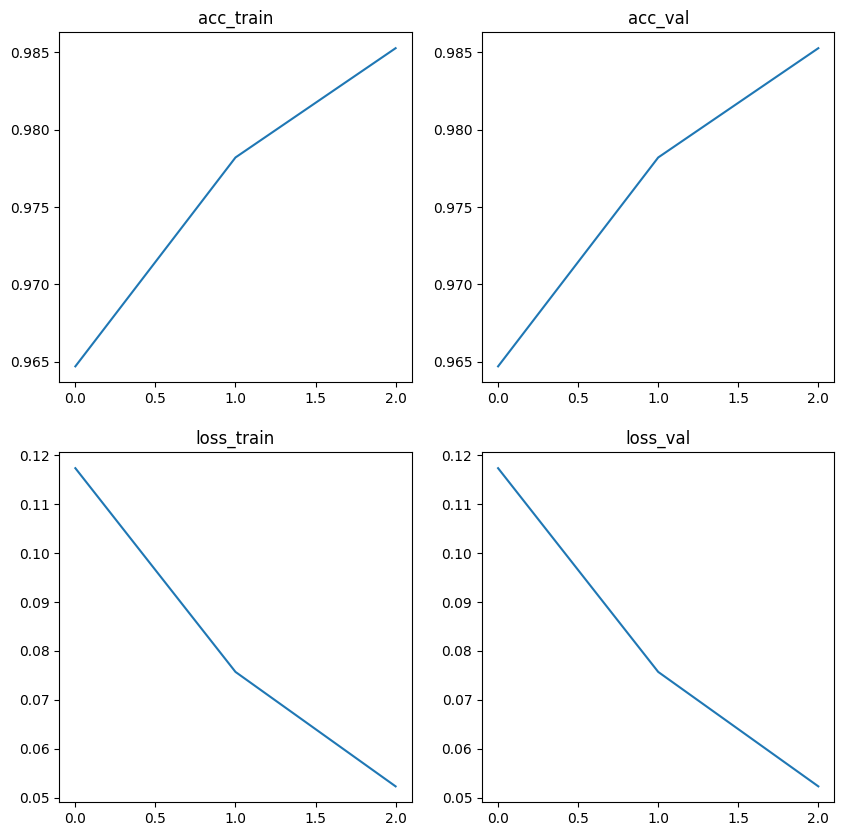

In [26]:
_, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

ox = list(range(3))

axes[0][0].plot(ox, data['acc_train'])
axes[0][0].title.set_text('acc_train')

axes[0][1].plot(ox, data['acc_val'])
axes[0][1].title.set_text('acc_val')

axes[1][0].plot(ox, data['loss_train'])
axes[1][0].title.set_text('loss_train')

axes[1][1].plot(ox, data['loss_val'])
axes[1][1].title.set_text('loss_val')

plt.show()